In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

## Load data

Load in the data and handle multiple rows for the same day in speeches.csv the same way in the R solution:

In [2]:
import pandas as pd

# load in the data, note your paths to the data may be different from what are showing here
fx = pd.read_csv("fx.csv", skiprows=4, na_values=['-'])
fx.columns = ["date", "exchange_rate"]
fx.dropna(inplace=True)

speeches = pd.read_csv("speeches.csv", sep='|', usecols=['date', 'contents'])
speeches.dropna(inplace=True)


In [ ]:
fx.isna().sum()

In [ ]:
fx.shape

In [ ]:
speeches.shape

In [ ]:
from collections import Counter
Counter(speeches.date)

In [ ]:
speeches['contents'][0]

In [ ]:
'apple' + ' orange'

In [ ]:
speeches.groupby("date").sum()

In [ ]:
speeches.groupby("date")['contents'].apply(lambda x: " ".join(x.astype(str)))

In [ ]:
speeches = speeches.groupby("date")['contents'].apply(lambda x: " ".join(x.astype(str))).reset_index()
speeches.shape

In [ ]:
speeches

In [ ]:
fx

In [ ]:
pd.merge(fx, speeches, on ='date').isna().sum()

In [ ]:
fx.shape

In [ ]:
pd.merge(fx, speeches, on ='date')

In [17]:
df = pd.merge(fx, speeches, on ='date', how = 'left')

In [ ]:
df

In [ ]:
df.dtypes

In [20]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.dtypes

In [22]:
.set_index('date', inplace= True)

In [ ]:
df

In [ ]:
df.dtypes

## Remove entries with obvious outliers or mistakes

We first see if there is any obvious outliers or mistakes by plotting the data:

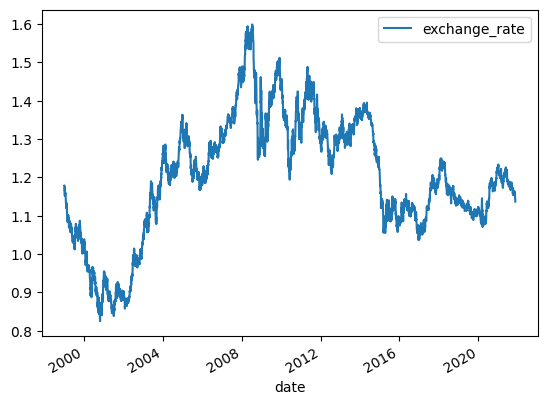

In [25]:
df.plot();

And look at the summary statistics:

In [ ]:
df.describe()

The data does not seem to have obvious outliers or mistakes. 

## 3.	Handle missing observations

We can see that there are some missing data:

In [ ]:
df.isna().sum()

Here we fill in the exchange rate with the latest information available:

In [28]:
df.exchange_rate.fillna(method='bfill', inplace=True)

We can see there is no more missing data for exchange rate:

In [ ]:
df.isna().sum()


## 4. Exchange rate return

Get the return by using the formula: $R_{t} = \frac{P_{t}-P_{t-1}}{P_{t-1}}$

Extend the original dataset with the following variables: “good_news” (equal to 1 when the exchange rate return is larger than 0.5 percent, 0 otherwise) and “bad_news” (equal to 1 when the exchange rate return is lower than -0.5 percent, 0 otherwise).

In [30]:
df['return'] = df.exchange_rate.diff(-1)/df.exchange_rate

In [ ]:
df

In [ ]:
(df['return'] > 0.005).astype(int)

In [ ]:
0.5/100

In [ ]:
(df['return'] > 0.5/100).astype(int)

Extend the dataset with the variables "good_news" and "bad_news":

In [35]:
df['good_news'] = (df['return'] > 0.5/100).astype(int)
df['bad_news'] = (df['return'] < -0.5/100).astype(int)

In [36]:
df['good_news'] = df['return'].apply(lambda x: 1 if x > 0.005 else 0)
df['bad_news'] = df['return'].apply(lambda x: 1 if x < -0.005 else 0)

In [ ]:
df.describe()

## 5. Associate words with `good_news`, `bad_news`

Get the contents that associate with `good_news` and `bad_news`:

In [ ]:
# remove rows with NA 
df.dropna(inplace=True)
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.shape

In [76]:
# get the contents related to "good_news" and "bad_news"
good_news_contents = df.contents[df.good_news==1].str.cat(sep=' ')
bad_news_contents = df.contents[df.bad_news==1].str.cat(sep=' ')

Load in some stop words, which are words that used to form a sentence but does not add much meaning to a sentence. Example of stop words are "a", "the" "does", "i", etc. 

In [77]:
stop_words = set(pd.read_csv("stopwords.txt", header=None).iloc[:,0].tolist())

In [ ]:
len(stop_words)

The function below helps us to get the most common words (excluding stop_words) related to `good_news` and `bad_news`. Please read the comments to understand how it works:

In [95]:
import string
import collections

def get_word_freq(contents, stop_words, num_words):
    freq = dict()
    
    
    for word in contents.split():
        word = word.strip(string.punctuation+'–')
        word = word.lower()
        if word not in stop_words and len(word):
            if word in freq:
                freq[word] += 1
            else:
                freq[word] = 1
                
                
    freq = dict(sorted(freq.items(), key = lambda item: -item[1]))
    return list(freq.keys())[:num_words]


Use the function above to get the 20 most common words associated with `good_news` and `bad_news`

In [96]:
good_indicators = get_word_freq(good_news_contents, stop_words, num_words = 20)
bad_indicators = get_word_freq(bad_news_contents, stop_words, num_words = 20)

In [ ]:
good_indicators

In [ ]:
bad_indicators

Note that many terms appear in both, and the results are not the same as R. It may because the `word_tokenizer()` in R may not work the same way as `split()` with `strip()`.